In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import pandas as pd
from scipy.optimize import minimize
from uncertainties import ufloat

data = pd.read_csv( 'data.csv')

In [2]:
def create_spline( x, y, xmin, xmax, xerr, yerr, fmt, color, text=''):
  xax = np.linspace( xmin, xmax, 1000)
  p, cov = np.polyfit( x, y, deg=3, cov=True)

  cov = np.sqrt( np.diag( cov))

  plt.errorbar( x, y, xerr=xerr, yerr=yerr, fmt=fmt)
  plt.plot( xax,
            p[0] * xax**3 + p[1] * xax**2 + p[2] * xax + p[3],
            color=color, label=text)

  return [p, cov]

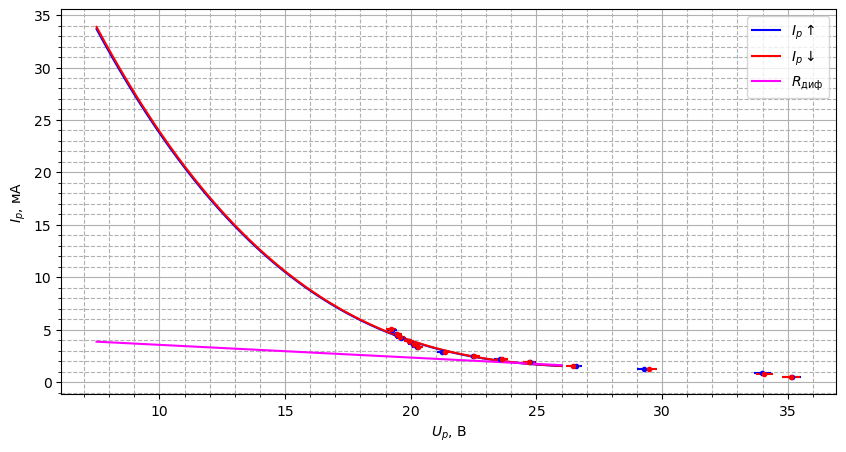

In [3]:
Ip = data['Ip, мА']
Up = data['Up, В']

EPS = 0.01

Ierr = Ip * EPS
Uerr = Up * EPS

PEAK_IDX = 14

plt.figure( figsize=(10, 5))

create_spline( Up[:PEAK_IDX], Ip[:PEAK_IDX],
               xmin=7.5, xmax=26,
               xerr=Uerr[:PEAK_IDX], yerr=Ierr[:PEAK_IDX],
               fmt='b.', color='blue', text='$I_p\\uparrow$')

create_spline( Up[PEAK_IDX:], Ip[PEAK_IDX:],
               xmin=7.5, xmax=26,
               xerr=Uerr[PEAK_IDX:], yerr=Ierr[PEAK_IDX:],
               fmt='r.', color='red', text='$I_p\\downarrow$')

# касательная и дифференциальное напряжение
slope = (ufloat( Ip[PEAK_IDX - 3], Ierr[PEAK_IDX - 3])
- ufloat( Ip[PEAK_IDX - 1], Ierr[PEAK_IDX - 1])) / (ufloat( Up[PEAK_IDX - 3], Uerr[PEAK_IDX - 3]) - ufloat( Up[PEAK_IDX - 1], Uerr[PEAK_IDX - 1]))
inter = Ip[PEAK_IDX - 1] - slope.nominal_value * Up[PEAK_IDX - 1]

xax = np.linspace( 7.5, 26, 1000)
plt.plot( xax, slope.nominal_value * xax + inter,
          color='magenta', label='$R_{\\text{диф}}$')

R_dif = 1 / slope

plt.xlabel( '$U_p$, В')
plt.ylabel( '$I_p$, мА')
plt.grid( which='major', linestyle='-')
plt.grid( which='minor', linestyle='--')
plt.minorticks_on()
plt.legend()

plt.savefig( 'vah.pdf')

In [4]:
R_dif

-8.244658567239217+/-0.6567668582512074

In [5]:
# I(U) - зондовые характеристики
U = []
I = []

for i in range (1, 4):
  U.append( list( data[f'U+{i}, В'])   + list( -data[f'U-{i}, В']))
  I.append( list( data[f'I+{i}, мкА']) + list( -data[f'I-{i}, мкА']))

In [6]:
def clear_from_nans( arr):
  arr = np.array( arr)
  arr = arr[~np.isnan( arr)]
  return arr

In [7]:
from scipy.optimize import curve_fit

def plot_zond(x, y, xerr=0, yerr=0, color='blue', label='', fmt=''):
  plt.errorbar(x, y, xerr=xerr, yerr=yerr, fmt=fmt)
  volt = lambda u, a, b, c: a * np.tanh( b * u) + c * u

  xax = np.linspace( min(x), max(x), 1000)
  #print( y.size)

  popt, pcov = curve_fit( volt, xdata=x, ydata=y)
  plt.plot( xax, volt( xax, *popt), color=color, label=label)
  return (popt, pcov)

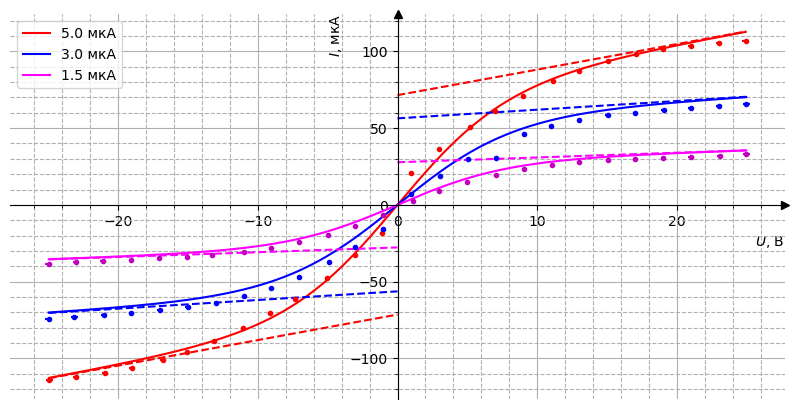

In [8]:
from uncertainties import unumpy as unp

fig, ax = plt.subplots( figsize=(10, 5))
# Move the left and bottom spines to x = 0 and y = 0, respectively.
ax.spines[["left", "bottom"]].set_position(("data", 0))
# Hide the top and right spines.
ax.spines[["top", "right"]].set_visible(False)

ax.plot(1, 0, ">k", transform=ax.get_yaxis_transform(), clip_on=False)
ax.plot(0, 1, "^k", transform=ax.get_xaxis_transform(), clip_on=False)

colors = ['red', 'blue', 'magenta']
fmts   = ['r.' , 'b.'  , 'm.']
labels = ['5.0 мкА', '3.0 мкА', '1.5 мкА']

Inas, slopes = [], []
Te = []
ne = []

ELECT = 1.6e-19
ME    = 0.91e-30
KB    = 1.38e-23

for i in range( len(U)):
  U[i] = clear_from_nans( U[i])
  I[i] = clear_from_nans( I[i])
  Uerr = [abs(j * EPS) for j in U[i]]
  Ierr = [abs(j * EPS) for j in I[i]]
  #print( I[i])
  (popt, pcov) = plot_zond( U[i], I[i], xerr=Uerr, yerr=Ierr, color=colors[i], label=labels[i], fmt=fmts[i])

  pcov = np.sqrt( np.diag( pcov))
  # текущий ток насыщения
  Inas.append( ufloat( popt[0], pcov[0]))

  # y'(0) = ab + c
  slopes.append( ufloat( popt[0], pcov[0]) * ufloat( popt[1], pcov[1])
                 + ufloat( popt[2], pcov[2]))

  Te.append( ELECT / (2 * KB * ufloat( popt[1], pcov[1])))

  ne.append( Inas[i] / ( 0.4 * ELECT * np.pi * 0.2 * 5.2 * unp.sqrt( 2 * KB * Te[i] / ME)))

  xax = np.linspace( 0, max(U[i]), 1000)
  plt.plot( xax, popt[0] + popt[2] * xax, color=colors[i] , linestyle='--')
  xax = np.linspace( min( U[i]), 0)
  plt.plot( xax, -popt[0] + popt[2] * xax, color=colors[i], linestyle='--')

ax.grid( which='major', linestyle='-')
ax.grid( which='minor', linestyle='--')
ax.minorticks_on()
ax.set_xlabel( '$U$, В'  , loc='right')
ax.set_ylabel( '$I$, мкА', loc='top')
ax.legend()
plt.savefig( 'zond.pdf')

In [9]:
Inas

[71.51008887688258+/-8.68215093901598,
 56.38531143739+/-13.198669786503666,
 27.760225525863945+/-5.670232501724218]

In [10]:
slopes

[10.80255906158544+/-1.6698291576910909,
 7.357676228529662+/-2.3291386290529172,
 3.8768684360180066+/-1.096670532937683]

In [11]:
Te

[45364.80975845436+/-5870.096232637381,
 48115.569689058866+/-11300.326062744327,
 45141.40370820984+/-9844.372631372664]

In [12]:
for i in range( len( ne)):
  ne[i] /= 1e14
ne

[2.9154845209105207+/-0.4010958487458151,
 2.2321641900334535+/-0.5845670362095375,
 1.1345886359184312+/-0.26270239328382644]

In [13]:
ELECT = 4.8e-10
ME *= 1e3

wp = [( (4 * np.pi * n * 1e8 * ELECT**2) / ME)**0.5 for n in ne]
for i in range( len( wp)):
  wp[i] /= 1e8

wp

[9.631209796970976+/-0.6625036490947717,
 8.427301689262285+/-1.103485754706479,
 6.008204246255263+/-0.695569118560597]

In [14]:
KB = 1.38e-16

rd = [( (KB * 300) / (4 * np.pi * n * 1e8 * ELECT**2))**0.5 for n in ne]
for i in range( len( rd)):
  rd[i] *= 100
rd

[0.7003233894454924+/-0.04817326284388234,
 0.8003702416479874+/-0.10480189184099925,
 1.1226251993146343+/-0.12996619095429116]

In [15]:
rde = [( (KB * Te[i]) / (4 * np.pi * ne[i] * 1e8 * ELECT**2))**0.5
       for i in range(len( ne))]
for i in range( len( rd)):
  rde[i] *= 100
rde

[8.611871694908418+/-0.9858069499883648,
 10.13615216557888+/-2.1436196641698433,
 13.770879845910642+/-2.655381207314021]

In [16]:
N_d = [4 / 3 * np.pi * (rd[i]/100)**3 * ne[i] * 1e8 for i in range( len(rd))]
N_d

[419.4645301366231+/-28.853777224200357,
 479.3884259870757+/-62.77196646726519,
 672.4057183394943+/-77.84433312366401]

In [17]:
NL = 2.69e20
alpha = [n * 1e14 / NL for n in ne]
for i in range( len( alpha)):
  alpha[i] *= 1e7

alpha

[10.838232419741711+/-1.491062634742807,
 8.298008141388303+/-2.173111658771515,
 4.2178016205146145+/-0.9765888226164551]

In [18]:
res = pd.DataFrame()

I_p = [5, 3, 1.5]

res['$I_p$, мА']       = I_p
res['$T_e$, $10^3$ K'] = [f'${t.nominal_value / 1e4: .1f} \\pm {t.std_dev / 1e4: .1f}$'
                          for t in Te]
res['$n_e$, $10^{-14}$ м$^{-3}$'] = [f'${n.nominal_value:.1f} \\pm {n.std_dev:.1f}$'
                                     for n in ne]
res['$\\omega_p$, $10^8$ рад/с'] = [f'${w.nominal_value:.1f} \\pm {w.std_dev:.1f}$'
                                    for w in wp]
res[r'$r_{D_e}$, $10^{-4}$ м'] = [f'${r.nominal_value:.0f} \\pm {r.std_dev:.0f}$'
                                  for r in rde]
res[r'$r_D$, $10^{-4}$ м'] = [f'${r.nominal_value:.1f} \\pm {r.std_dev:.1f}$'
                                  for r in rd]
res[r'$N_D$'] = [f'${n.nominal_value:.0f} \\pm {n.std_dev:.0f}$'
                         for n in N_d]
res['$\\alpha$, $10^{-7}$'] = [f'${a.nominal_value:.1f} \\pm {a.std_dev:.1f}$'
                               for a in alpha]

In [19]:
def latex_tab(df):
  tab = df.to_latex(index=False, float_format='%.1f')
  tab = tab.replace('\\\\\n', '\\\\ \\hline\n')
  tab = tab.replace('\\toprule', '\\hline')
  tab = tab.replace('\\midrule\n', '')
  tab = tab.replace('\\bottomrule\n', '')
  return tab

In [20]:
print( latex_tab( res))

\begin{tabular}{rlllllll}
\hline
$I_p$, мА & $T_e$, $10^3$ K & $n_e$, $10^{-14}$ м$^{-3}$ & $\omega_p$, $10^8$ рад/с & $r_{D_e}$, $10^{-4}$ м & $r_D$, $10^{-4}$ м & $N_D$ & $\alpha$, $10^{-7}$ \\ \hline
5.0 & $ 4.5 \pm  0.6$ & $2.9 \pm 0.4$ & $9.6 \pm 0.7$ & $9 \pm 1$ & $0.7 \pm 0.0$ & $419 \pm 29$ & $10.8 \pm 1.5$ \\ \hline
3.0 & $ 4.8 \pm  1.1$ & $2.2 \pm 0.6$ & $8.4 \pm 1.1$ & $10 \pm 2$ & $0.8 \pm 0.1$ & $479 \pm 63$ & $8.3 \pm 2.2$ \\ \hline
1.5 & $ 4.5 \pm  1.0$ & $1.1 \pm 0.3$ & $6.0 \pm 0.7$ & $14 \pm 3$ & $1.1 \pm 0.1$ & $672 \pm 78$ & $4.2 \pm 1.0$ \\ \hline
\end{tabular}



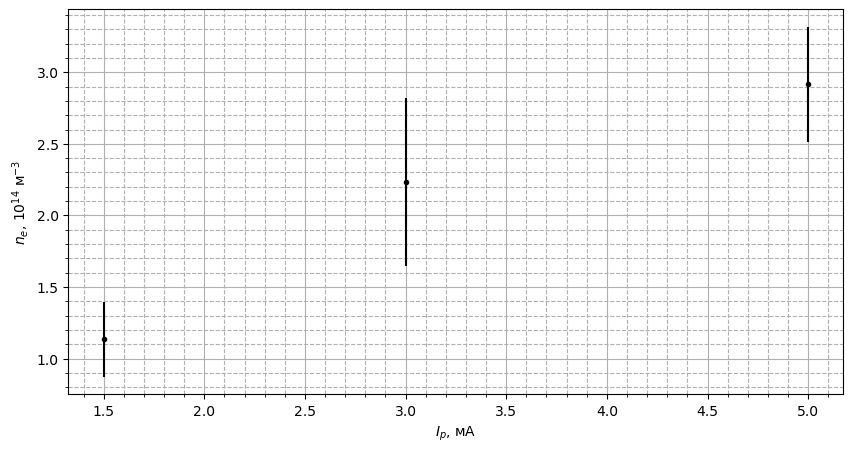

In [21]:
plt.figure( figsize=(10, 5))
plt.errorbar( I_p, [n.nominal_value for n in ne], yerr=[n.std_dev for n in ne], fmt='k.')

plt.xlabel( '$I_p$, мА')
plt.ylabel( r'$n_e$, $10^{14}$ м$^{-3}$')
plt.grid( which='major', linestyle='-')
plt.grid( which='minor', linestyle='--')
plt.minorticks_on()
plt.savefig( 'n.pdf')

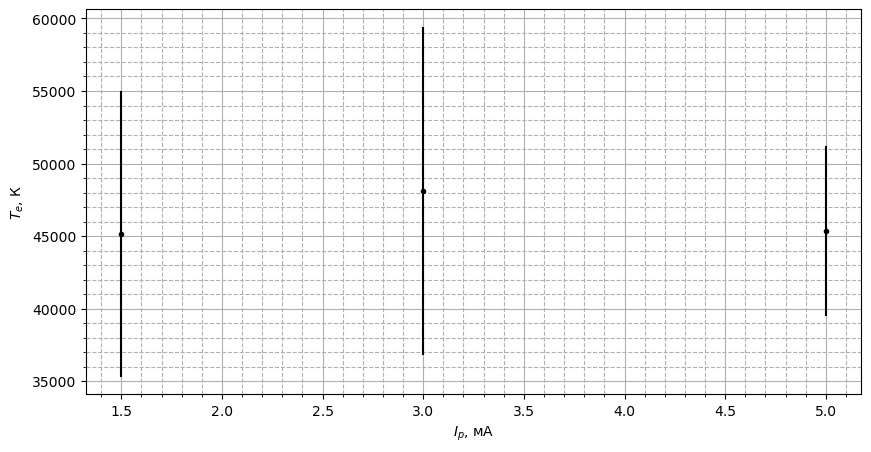

In [22]:
plt.figure( figsize=(10, 5))
plt.errorbar( I_p, [n.nominal_value for n in Te], yerr=[n.std_dev for n in Te], fmt='k.')

plt.xlabel( '$I_p$, мА')
plt.ylabel( r'$T_e$, К')
plt.grid( which='major', linestyle='-')
plt.grid( which='minor', linestyle='--')
plt.minorticks_on()
plt.savefig( 't.pdf')